### Imports

In [223]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [180]:
train_csv_path = '/Users/nathanjones/Downloads/KaggleMLComps/LoanApprovalPrediction/Data/train.csv'
test_csv_path = '/Users/nathanjones/Downloads/KaggleMLComps/LoanApprovalPrediction/Data/test.csv'
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

### Data Overview 


In [181]:
cols = df_train.columns.to_list

explanation of each variable:

1. **id** 🆔: Unique identifier for each loan applicant or entry.  

2. **person_age** 👤📅: Age of the individual applying for the loan. 

3. **person_income** 💰: Annual income of the applicant.  

4. **person_home_ownership** 🏠: Type of home ownership (e.g., Rent, Own, Mortgage, etc.).  

5. **person_emp_length** 📆💼: Length of employment in years (may include nulls for unemployed).  

6. **loan_intent** 🎯: Purpose of the loan (e.g., education, medical, debt consolidation, etc.).  

7. **loan_grade** 🏅: Internal credit rating or grade assigned to the loan (e.g., A, B, C, etc.).  

8. **loan_amnt** 💳: Amount of the loan requested or approved.  

9. **loan_int_rate** 📈: Interest rate assigned to the loan.  

10. **loan_percent_income** 💸: Loan amount as a percentage of the applicant's income.  

11. **cb_person_default_on_file** ❌🗂️: Whether the applicant has a history of default (Yes/No) on file with a credit bureau.  
12. **cb_person_cred_hist_length** 📜⏳: Length of the applicant's credit history in years. 

13. **loan_status** ✅❌: Target variable indicating loan outcome (e.g., approved or rejected, or a binary status such as fully paid vs. defaulted).  
 


In [182]:
df_train.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [183]:
df_train.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [184]:
numerical = df_train.select_dtypes(include=['number'])
numerical = numerical.drop(columns=['id'])
categorical = df_train.select_dtypes(include=['object'])

In [185]:
numerical.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,37,35000,0.0,6000,11.49,0.17,14,0
1,22,56000,6.0,4000,13.35,0.07,2,0
2,29,28800,8.0,6000,8.90,0.21,10,0
3,30,70000,14.0,12000,11.11,0.17,5,0
4,22,60000,2.0,6000,6.92,0.10,3,0


In [186]:
categorical.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N
2,OWN,PERSONAL,A,N
3,RENT,VENTURE,B,N
4,RENT,MEDICAL,A,N


### Target 

**unbalanced** dataset  

Will need to adjust class weights accordingly

Text(0.5, 1.0, 'Distribution of Target: Loan Status')

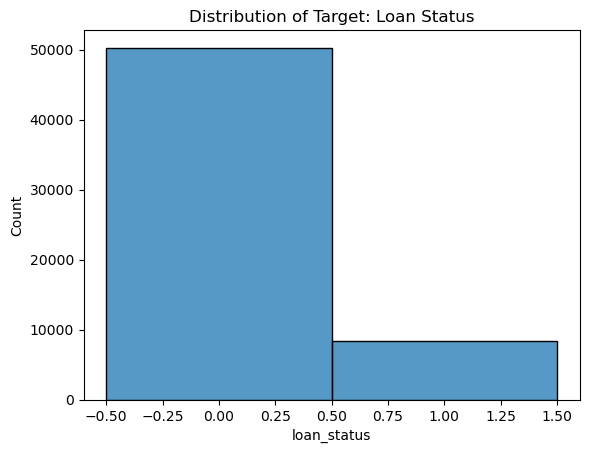

In [187]:
ax = sns.histplot(df_train['loan_status'], discrete=True)
ax.set_title('Distribution of Target: Loan Status')


In [188]:
loan_status_cnt =df_train['loan_status'].value_counts()
loan_status_pct = df_train['loan_status'].value_counts(normalize=True)*100
loan_status_summary = pd.DataFrame({
    'counts':loan_status_cnt,
    'pct':loan_status_pct
})
loan_status_summary



,counts,pct
loan_status,,
0,50295,85.761787
1,8350,14.238213


### Numeric Values Distribution

**Outliers** might need culling if model performs badly.

In [189]:
scaler = MinMaxScaler()
numerical_normalised = scaler.fit_transform(numerical)
numerical_normalised = pd.DataFrame(numerical_normalised, columns=numerical.columns)



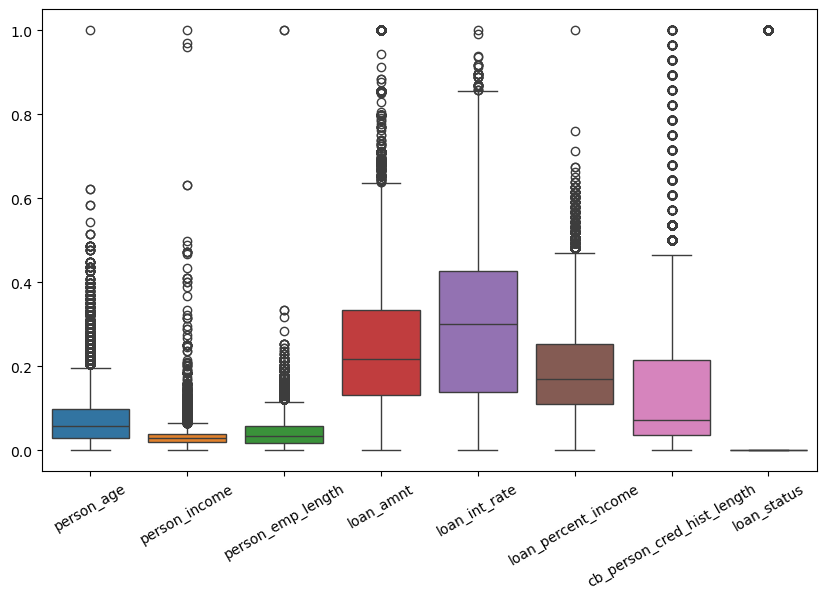

In [190]:
plt.figure(figsize=(10,6))
sns.boxplot(data=numerical_normalised)
plt.xticks(rotation=30);


### Numeric Variable Relationships

1. **Correlation** loan_int_rate and loan_percent_income correlate most with loan_status.  

2. **Interaction** between loan_amount and loan_percent_income shows a slight positive correlation with the target (loan_status) when analyzed together, even though their individual correlations with the target are weak. This suggests that their combined effect may hold predictive value:  
**NEW FEATURE loan_amnt_times_percent_income    CORELATION 0.307652**

<Axes: >

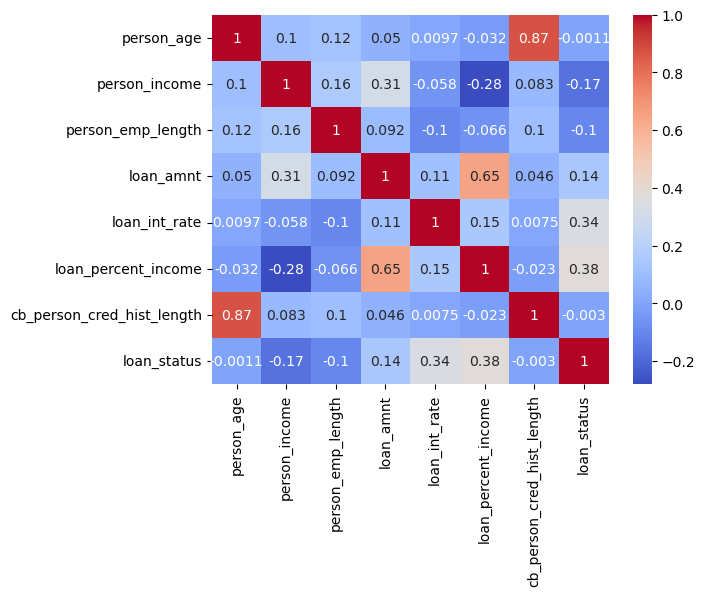

In [191]:
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm')

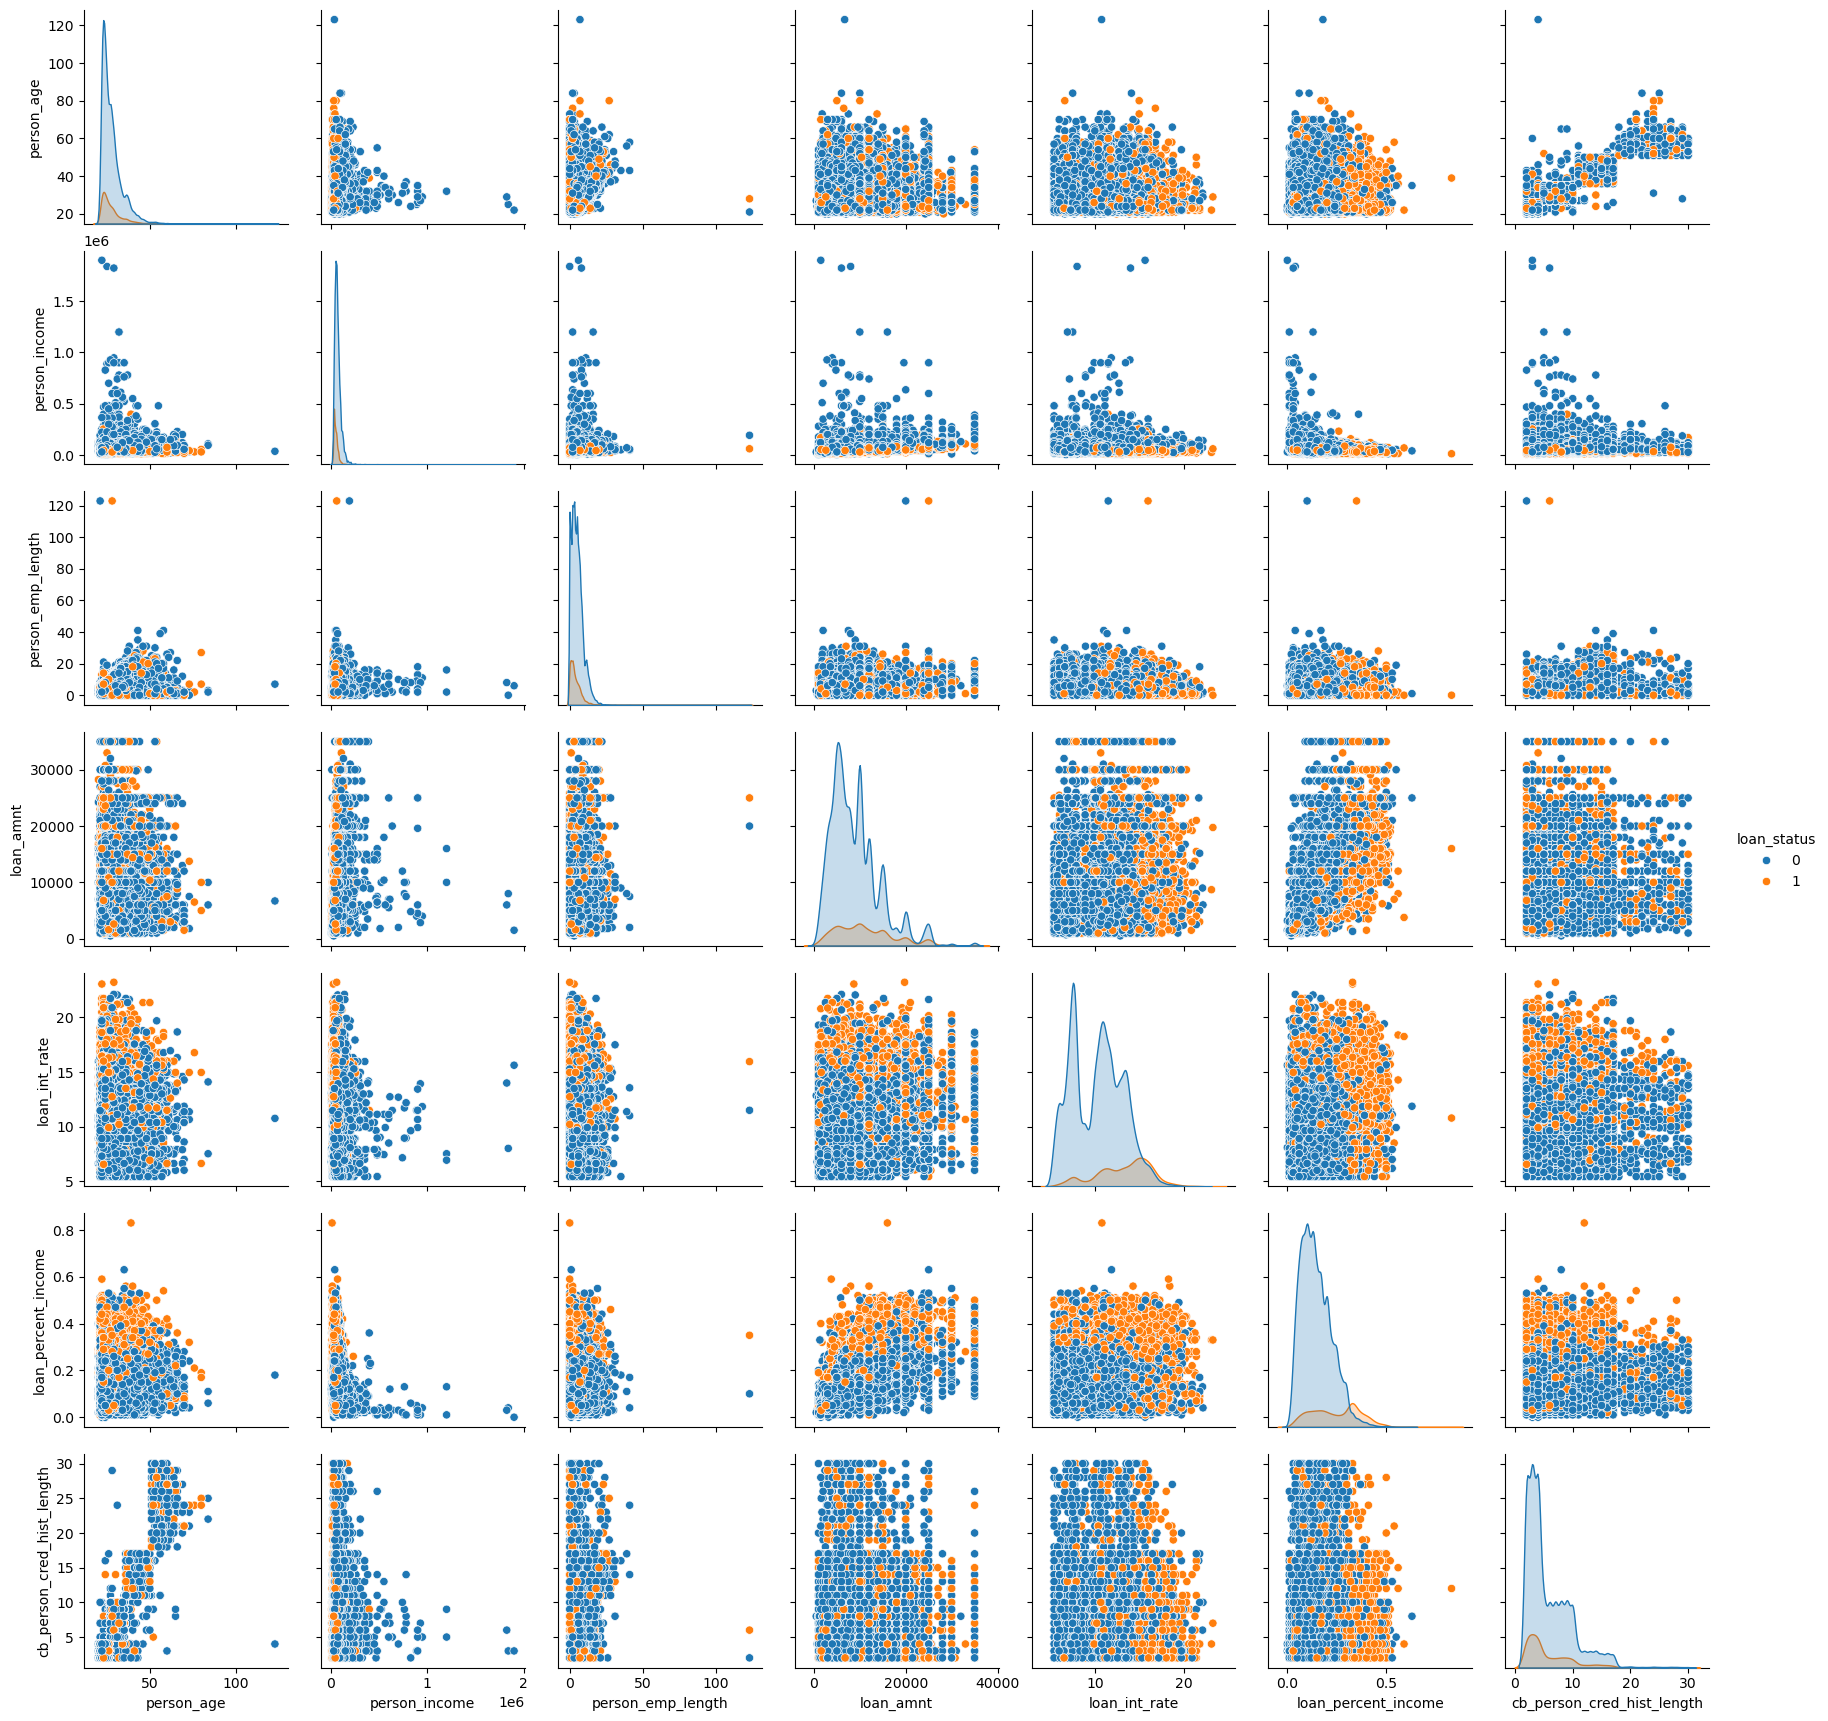

In [192]:
sns.pairplot(numerical, hue='loan_status')

In [204]:
df_train['loan_amnt_to_percent_income'] = df_train['loan_amnt'] / df_train['loan_percent_income']  # Ratio
df_train['loan_amnt_times_percent_income'] = df_train['loan_amnt'] * df_train['loan_percent_income']  # Product
df_train['loan_amnt_log_product'] = np.log1p(df_train['loan_amnt'] * df_train['loan_percent_income'])  # Log-transformed product

#applying the same to test
df_test['loan_amnt_times_percent_income'] = df_test['loan_amnt'] * df_test['loan_percent_income']  # Product


# Step 2: Check correlation of new features with the target
correlation_with_target = df_train[['loan_amnt_to_percent_income', 
                              'loan_amnt_times_percent_income', 
                              'loan_amnt_log_product', 
                              'loan_status']].corr()

# Extracting the correlation of new features with 'loan_status'
correlations = correlation_with_target['loan_status'].drop('loan_status')

# Display the correlations
print("Correlation of new features with loan_status:")
print(correlations)

Correlation of new features with loan_status:
loan_amnt_to_percent_income      -0.167628
loan_amnt_times_percent_income    0.307652
loan_amnt_log_product             0.218164
Name: loan_status, dtype: float64


### Categorical Variables Distribution

In [194]:
categorical['person_home_ownership'].value_counts(normalize=True)*100

person_home_ownership
RENT        52.168130
MORTGAGE    42.329269
OWN          5.350840
OTHER        0.151761
Name: proportion, dtype: float64

In [195]:
categorical['loan_intent'].value_counts(normalize=True)*100

loan_intent
EDUCATION            20.924205
MEDICAL              18.644386
PERSONAL             17.079035
VENTURE              17.070509
DEBTCONSOLIDATION    15.573365
HOMEIMPROVEMENT      10.708500
Name: proportion, dtype: float64

In [196]:
categorical['loan_grade'].value_counts(normalize=True)*100

loan_grade
A    35.781397
B    34.785574
C    18.818314
D     8.583852
E     1.720522
F     0.254071
G     0.056271
Name: proportion, dtype: float64

In [197]:
categorical['cb_person_default_on_file'].value_counts(normalize=True)*100

cb_person_default_on_file
N    85.161565
Y    14.838435
Name: proportion, dtype: float64

In [198]:
categorical.nunique()

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

### Categorical Variable & Target Relationship

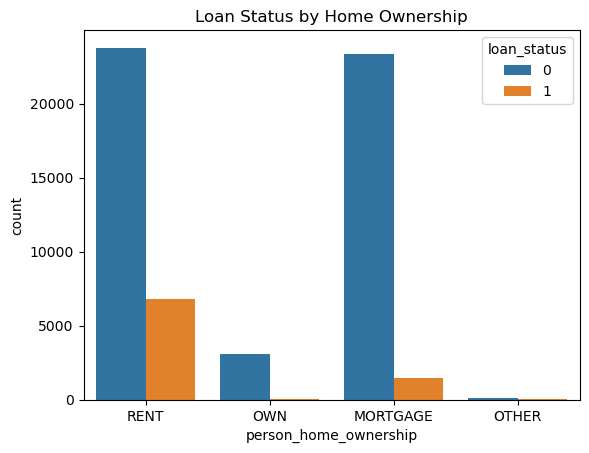

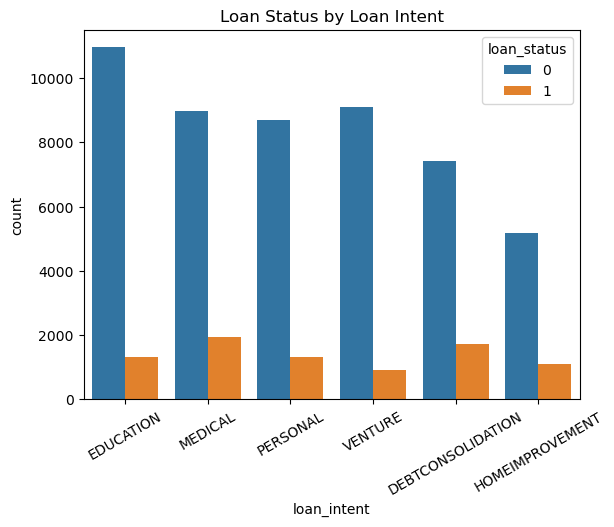

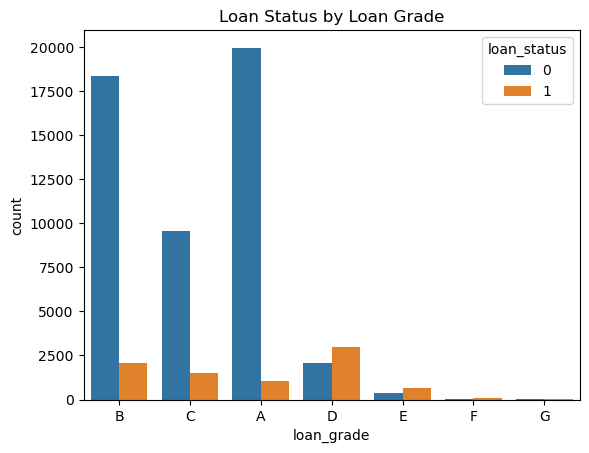

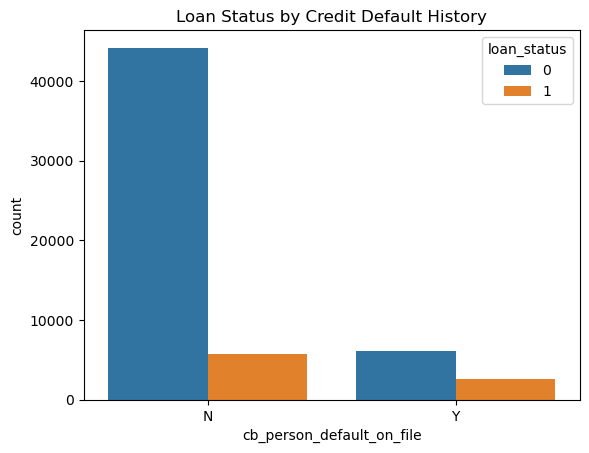

In [199]:
sns.countplot(data=df_train, x='person_home_ownership', hue='loan_status')
plt.title('Loan Status by Home Ownership')
plt.show()

sns.countplot(data=df_train, x='loan_intent', hue='loan_status')
plt.title('Loan Status by Loan Intent')
plt.xticks(rotation=30)
plt.show()

sns.countplot(data=df_train, x='loan_grade', hue='loan_status')
plt.title('Loan Status by Loan Grade')
plt.show()

sns.countplot(data=df_train, x='cb_person_default_on_file', hue='loan_status')
plt.title('Loan Status by Credit Default History')
plt.show()


### Categorical and Numerical Relationships - Encoding Potential

1. Encoding loan_amnt based on the average value per loan_grade.  

**CAREFUL, Data Leakage** Transform to Train and Test separately 

2. OneHoteEncode the remainder.  

**CAREFUL, Data Leakage** FIT TRANSFORM to train, only; TRANSFORM test, only. separately 

<Axes: xlabel='loan_grade', ylabel='loan_amnt'>

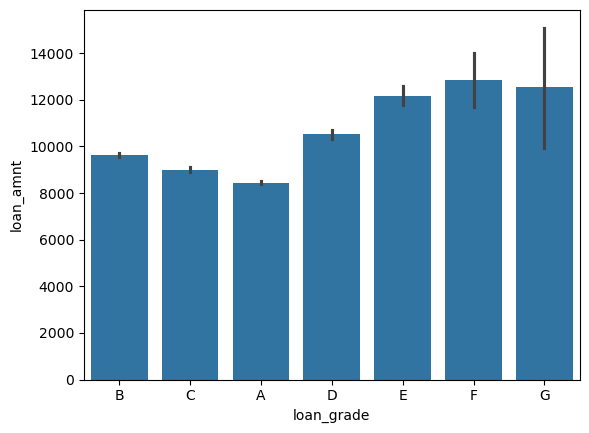

In [200]:
sns.barplot(x=df_train['loan_grade'], y=df_train['loan_amnt'])

### Preprocessing Data

In [205]:
# Num Variable Engineering as Previously Identified
df_train['loan_amnt_times_percent_income'] = df_train['loan_amnt'] * df_train['loan_percent_income']  # Product
df_test['loan_amnt_times_percent_income'] = df_test['loan_amnt'] * df_test['loan_percent_income']  # Produc


#Categorical Engineering as Previouly Identified
df_train['loan_grade_avg_amnt'] = df_train.groupby('loan_grade')['loan_amnt'].transform('mean')
df_test['loan_grade_avg_amnt'] = df_test.groupby('loan_grade')['loan_amnt'].transform('mean')

In [206]:
""" # List of categorical columns to encode (excluding 'loan_grade' and 'loan_amnt')
categorical_columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

# Initialize the OneHotEncoder with sparse=False (to get a dense matrix)
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids multicollinearity

# Step 1: Apply OneHotEncoder to the categorical columns of both train and test sets
X_train_encoded = onehot_encoder.fit_transform(df_train[categorical_columns])
X_test_encoded = onehot_encoder.transform(df_test[categorical_columns])

# Step 2: Convert the transformed data back into DataFrames with proper column names
encoded_column_names = onehot_encoder.get_feature_names_out(categorical_columns)
encoded_df_train = pd.DataFrame(X_train_encoded, columns=encoded_column_names)
encoded_df_test = pd.DataFrame(X_test_encoded, columns=encoded_column_names)

# Step 3: Create the engineered column (avg loan_amnt per loan_grade) for both train and test
df_train['loan_grade_avg_amnt'] = df_train.groupby('loan_grade')['loan_amnt'].transform('mean')
df_test['loan_grade_avg_amnt'] = df_test.groupby('loan_grade')['loan_amnt'].transform('mean')

# Step 4: Drop the original categorical columns and merge the transformed data
df_train_encoded = pd.concat([encoded_df_train, df_train.drop(columns=categorical_columns + ['loan_amnt', 'loan_grade'])], axis=1)
df_test_encoded = pd.concat([encoded_df_test, df_test.drop(columns=categorical_columns + ['loan_amnt', 'loan_grade'])], axis=1)

# Check the transformed data
print(df_train_encoded.columns) """


" # List of categorical columns to encode (excluding 'loan_grade' and 'loan_amnt')\ncategorical_columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']\n\n# Initialize the OneHotEncoder with sparse=False (to get a dense matrix)\nonehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids multicollinearity\n\n# Step 1: Apply OneHotEncoder to the categorical columns of both train and test sets\nX_train_encoded = onehot_encoder.fit_transform(df_train[categorical_columns])\nX_test_encoded = onehot_encoder.transform(df_test[categorical_columns])\n\n# Step 2: Convert the transformed data back into DataFrames with proper column names\nencoded_column_names = onehot_encoder.get_feature_names_out(categorical_columns)\nencoded_df_train = pd.DataFrame(X_train_encoded, columns=encoded_column_names)\nencoded_df_test = pd.DataFrame(X_test_encoded, columns=encoded_column_names)\n\n# Step 3: Create the engineered column (avg loan_amnt per loan_grade)

### Training

In [207]:
model = LogisticRegression()

In [225]:
features = ['loan_int_rate', 'loan_percent_income', 'loan_amnt_times_percent_income', 'loan_grade_avg_amnt']




### Metrics

In [224]:
#y_pred_proba = model.predict_proba(X_test)[:,1]
#roc_score = roc_auc_score(y_test, y_pred_proba)
#print('roc score:', roc_score)